In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2024-03-18 06:06:39--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0s      

2024-03-18 06:06:39 (76.8 MB/s) - ‘visualization.py’ saved [13023/13023]



In [2]:
!pip install adjustText

In [3]:
from adjustText import adjust_text

# Download the dataset and train/test split

Load the dataset

In [4]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2024-03-18 06:07:21--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.03s   

2024-03-18 06:07:21 (7.57 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2024-03-18 06:07:21--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443

In [5]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])
#full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.13000000e+02
  0.00000000e+00 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.38000000e+02
  0.00000000e+00 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.13000000e+02
  0.00000000e+00 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.01000000e+02
  0.00000000e+00 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.13000000e+02
  0.00000000e+00 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.13000000e+02
  0.00000000e+00 2.00000000e+00]]


In [6]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,...,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,...,2595.0,8.0,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,...,2557.0,0.0,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,...,2595.0,8.0,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,...,2645.0,0.0,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,...,2914.0,0.0,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,0


In [7]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 27)
Possible labels  [0 1 2]


In [8]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

# Pre-processing
## Full Data

In [9]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])

data = full_df.to_numpy()

In [10]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

In [11]:
# We separate the last column in
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [12]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

In [13]:
num_samples_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5824]

# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp and other columns
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])

# Create a dictionary to store the modified DataFrames
modified_dfs = {}

# Iterate over the numbers of samples in the list
for i, num_samples in enumerate(num_samples_list):
    # Sample the DataFrame with the desired number of samples
    sampled_df = full_df.sample(n=num_samples, random_state=42)  # You can change the random_state if needed

    # Create a key for the dictionary based on the index (i)
    key = f"modified_df_{i+1}"

    # Store the sampled DataFrame in the dictionary
    modified_dfs[key] = sampled_df

# Now, modified_dfs is a dictionary containing different DataFrames with the desired number of samples for each specified value in the list

# Access the DataFrames later using the keys
for key, df in modified_dfs.items():
    print(f"{key} has {len(df)} samples.")


modified_df_1 has 500 samples.
modified_df_2 has 1000 samples.
modified_df_3 has 1500 samples.
modified_df_4 has 2000 samples.
modified_df_5 has 2500 samples.
modified_df_6 has 3000 samples.
modified_df_7 has 3500 samples.
modified_df_8 has 4000 samples.
modified_df_9 has 4500 samples.
modified_df_10 has 5000 samples.
modified_df_11 has 5824 samples.


In [14]:
train_x_list = []
train_y_list = []
test_x_list = []
test_y_list = []

for df in modified_dfs.values():
  df = df.to_numpy()
  train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=1 )

  # We separate the last column in
  train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
  train_y = train_y.reshape(-1).astype(int)

  test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
  test_y = test_y.reshape(-1).astype(int)

  train_y_list.append(train_y)
  test_y_list.append(test_y)

  min = train_x.min(axis=0)
  max = train_x.max(axis=0)

  train_x = (train_x - min)/(max - min)
  test_x = (test_x - min)/(max - min)

  train_x_list.append(train_x)
  test_x_list.append(test_x)

## 1000 Samples

In [15]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])

# Choose the number of samples you want to keep
num_samples_to_keep = 1000
# Extract the last column (labels)
labels = full_df.iloc[:, -1]

# Sample the specified number of rows
data_sampled = full_df.sample(n=num_samples_to_keep, random_state=1)

### 30 Features

In [16]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 30

# Keep the last column (labels) and the specified number of columns
modified_data_1 = data_sampled.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_1['labels'] = labels.loc[modified_data_1.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_1.shape

(1000, 27)

### 20 Features

In [17]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 20

# Keep the last column (labels) and the specified number of columns
modified_data_2 = data_sampled.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_2['labels'] = labels.loc[modified_data_2.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_2.shape

(1000, 21)

### 10 Features

In [18]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 10

# Keep the last column (labels) and the specified number of columns
modified_data_3 = data_sampled.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_3['labels'] = labels.loc[modified_data_3.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_3.shape

(1000, 11)

## 2500 Samples

In [19]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])

# Choose the number of samples you want to keep
num_samples_to_keep = 2500
# Extract the last column (labels)
labels = full_df.iloc[:, -1]

# Sample the specified number of rows
data_sampled_2 = full_df.sample(n=num_samples_to_keep, random_state=1)

### 30 Features

In [20]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 30

# Keep the last column (labels) and the specified number of columns
modified_data_2_1 = data_sampled_2.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_2_1['labels'] = labels.loc[modified_data_2_1.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_2_1.shape

(2500, 27)

### 20 Features

In [21]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 20

# Keep the last column (labels) and the specified number of columns
modified_data_2_2 = data_sampled_2.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_2_2['labels'] = labels.loc[modified_data_2_2.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_2_2.shape

(2500, 21)

### 10 Features

In [22]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 10

# Keep the last column (labels) and the specified number of columns
modified_data_2_3 = data_sampled_2.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_2_3['labels'] = labels.loc[modified_data_2_3.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_2_3.shape

(2500, 11)

## 5000 Samples

In [23]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])

# Choose the number of samples you want to keep
num_samples_to_keep = 5000
# Extract the last column (labels)
labels = full_df.iloc[:, -1]

# Sample the specified number of rows
data_sampled_3 = full_df.sample(n=num_samples_to_keep, random_state=1)

### 30 Features

In [24]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 30

# Keep the last column (labels) and the specified number of columns
modified_data_3_1 = data_sampled_3.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_3_1['labels'] = labels.loc[modified_data_3_1.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_3_1.shape

(5000, 27)

### 20 Features

In [25]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 20

# Keep the last column (labels) and the specified number of columns
modified_data_3_2 = data_sampled_3.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_3_2['labels'] = labels.loc[modified_data_3_2.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_3_2.shape

(5000, 21)

### 10 Features

In [26]:
# Choose the number of columns you want to keep (excluding the last column)
num_columns_to_keep = 10

# Keep the last column (labels) and the specified number of columns
modified_data_3_3 = data_sampled_3.iloc[:, :-1].iloc[:, :num_columns_to_keep]
modified_data_3_3['labels'] = labels.loc[modified_data_3_3.index]

# 'modified_data' now contains the specified number of columns and samples, with the last column as labels
modified_data_3_3.shape

(5000, 11)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [27]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Mounted at /content/gdrive


In [28]:
train_x_list  = []
test_x_list = []
train_y_list  = []
test_y_list = []

## Training data 1000, 30

In [29]:
modified_data_1 = modified_data_1.to_numpy()
train_1, test_1 = train_test_split(modified_data_1, test_size=0.2, shuffle=True, random_state=1 )

In [30]:
# We separate the last column in
train_x_1, train_y_1 = np.hsplit(train_1, [train_1.shape[1] - 1])
train_y_1 = train_y_1.reshape(-1).astype(int)

test_x_1, test_y_1 = np.hsplit(test_1, [test_1.shape[1] - 1])
test_y_1 = test_y_1.reshape(-1).astype(int)

train_y_list.append(train_y_1)
test_y_list.append(test_y_1)

In [31]:
min = train_x_1.min(axis=0)
max = train_x_1.max(axis=0)

train_x_1 = (train_x_1 - min)/(max - min)
test_x_1 = (test_x_1 - min)/(max - min)

train_x_list.append(train_x_1)
test_x_list.append(test_x_1)

## Training data 1000, 20

In [32]:
modified_data_2 = modified_data_2.to_numpy()
train_2, test_2 = train_test_split(modified_data_2, test_size=0.2, shuffle=True, random_state=1 )

In [33]:
# We separate the last column in
train_x_2, train_y_2 = np.hsplit(train_2, [train_2.shape[1] - 1])
train_y_2 = train_y_2.reshape(-1).astype(int)

test_x_2, test_y_2 = np.hsplit(test_2, [test_2.shape[1] - 1])
test_y_2 = test_y_2.reshape(-1).astype(int)

train_y_list.append(train_y_2)
test_y_list.append(test_y_2)

In [34]:
min = train_x_2.min(axis=0)
max = train_x_2.max(axis=0)

train_x_2 = (train_x_2 - min)/(max - min)
test_x_2 = (test_x_2 - min)/(max - min)

train_x_list.append(train_x_2)
test_x_list.append(test_x_2)

## Training data 1000, 10

In [35]:
modified_data_3 = modified_data_3.to_numpy()
train_3, test_3 = train_test_split(modified_data_3, test_size=0.2, shuffle=True, random_state=1 )

In [36]:
# We separate the last column in
train_x_3, train_y_3 = np.hsplit(train_3, [train_3.shape[1] - 1])
train_y_3 = train_y_3.reshape(-1).astype(int)

test_x_3, test_y_3 = np.hsplit(test_3, [test_3.shape[1] - 1])
test_y_3 = test_y_3.reshape(-1).astype(int)

train_y_list.append(train_y_3)
test_y_list.append(test_y_3)

In [37]:
min = train_x_3.min(axis=0)
max = train_x_3.max(axis=0)

train_x_3 = (train_x_3 - min)/(max - min)
test_x_3 = (test_x_3 - min)/(max - min)

train_x_list.append(train_x_3)
test_x_list.append(test_x_3)

## Training data 2500, 30

In [38]:
modified_data_2_1 = modified_data_2_1.to_numpy()
train_2_1, test_2_1 = train_test_split(modified_data_2_1, test_size=0.2, shuffle=True, random_state=1 )

In [39]:
# We separate the last column in
train_x_2_1, train_y_2_1 = np.hsplit(train_2_1, [train_2_1.shape[1] - 1])
train_y_2_1 = train_y_2_1.reshape(-1).astype(int)

test_x_2_1, test_y_2_1 = np.hsplit(test_2_1, [test_2_1.shape[1] - 1])
test_y_2_1 = test_y_2_1.reshape(-1).astype(int)

train_y_list.append(train_y_2_1)
test_y_list.append(test_y_2_1)

In [40]:
min = train_x_2_1.min(axis=0)
max = train_x_2_1.max(axis=0)

train_x_2_1 = (train_x_2_1 - min)/(max - min)
test_x_2_1 = (test_x_2_1 - min)/(max - min)

train_x_list.append(train_x_2_1)
test_x_list.append(test_x_2_1)

## Training data 2500, 20

In [41]:
modified_data_2_2 = modified_data_2_2.to_numpy()
train_2_2, test_2_2 = train_test_split(modified_data_2_2, test_size=0.2, shuffle=True, random_state=1 )

In [42]:
# We separate the last column in
train_x_2_2, train_y_2_2 = np.hsplit(train_2_2, [train_2_2.shape[1] - 1])
train_y_2_2 = train_y_2_2.reshape(-1).astype(int)

test_x_2_2, test_y_2_2 = np.hsplit(test_2_2, [test_2_2.shape[1] - 1])
test_y_2_2 = test_y_2_2.reshape(-1).astype(int)

train_y_list.append(train_y_2_2)
test_y_list.append(test_y_2_2)

In [43]:
min = train_x_2_2.min(axis=0)
max = train_x_2_2.max(axis=0)

train_x_2_2 = (train_x_2_2 - min)/(max - min)
test_x_2_2 = (test_x_2_2 - min)/(max - min)

train_x_list.append(train_x_2_2)
test_x_list.append(test_x_2_2)

## Training data 2500, 10

In [44]:
modified_data_2_3 = modified_data_2_3.to_numpy()
train_2_3, test_2_3 = train_test_split(modified_data_2_3, test_size=0.2, shuffle=True, random_state=1 )

In [45]:
# We separate the last column in
train_x_2_3, train_y_2_3 = np.hsplit(train_2_3, [train_2_3.shape[1] - 1])
train_y_2_3 = train_y_2_3.reshape(-1).astype(int)

test_x_2_3, test_y_2_3 = np.hsplit(test_2_3, [test_2_3.shape[1] - 1])
test_y_2_3 = test_y_2_3.reshape(-1).astype(int)

train_y_list.append(train_y_2_3)
test_y_list.append(test_y_2_3)

In [46]:
min = train_x_2_3.min(axis=0)
max = train_x_2_3.max(axis=0)

train_x_2_3 = (train_x_2_3 - min)/(max - min)
test_x_2_3 = (test_x_2_3 - min)/(max - min)

train_x_list.append(train_x_2_3)
test_x_list.append(test_x_2_3)

## Training data 5000, 30

In [47]:
modified_data_3_1 = modified_data_3_1.to_numpy()
train_3_1, test_3_1 = train_test_split(modified_data_3_1, test_size=0.2, shuffle=True, random_state=1 )

In [48]:
# We separate the last column in
train_x_3_1, train_y_3_1 = np.hsplit(train_3_1, [train_3_1.shape[1] - 1])
train_y_3_1 = train_y_3_1.reshape(-1).astype(int)

test_x_3_1, test_y_3_1 = np.hsplit(test_3_1, [test_3_1.shape[1] - 1])
test_y_3_1 = test_y_3_1.reshape(-1).astype(int)

train_y_list.append(train_y_3_1)
test_y_list.append(test_y_3_1)

In [49]:
min = train_x_3_1.min(axis=0)
max = train_x_3_1.max(axis=0)

train_x_3_1 = (train_x_3_1 - min)/(max - min)
test_x_3_1 = (test_x_3_1 - min)/(max - min)

train_x_list.append(train_x_3_1)
test_x_list.append(test_x_3_1)

## Training data 5000, 20

In [50]:
modified_data_3_2 = modified_data_3_2.to_numpy()
train_3_2, test_3_2 = train_test_split(modified_data_3_2, test_size=0.2, shuffle=True, random_state=1 )

In [51]:
# We separate the last column in
train_x_3_2, train_y_3_2 = np.hsplit(train_3_2, [train_3_2.shape[1] - 1])
train_y_3_2 = train_y_3_2.reshape(-1).astype(int)

test_x_3_2, test_y_3_2 = np.hsplit(test_3_2, [test_3_2.shape[1] - 1])
test_y_3_2 = test_y_3_2.reshape(-1).astype(int)

train_y_list.append(train_y_3_2)
test_y_list.append(test_y_3_2)

In [52]:
min = train_x_3_2.min(axis=0)
max = train_x_3_2.max(axis=0)

train_x_3_2 = (train_x_3_2 - min)/(max - min)
test_x_3_2 = (test_x_3_2 - min)/(max - min)

train_x_list.append(train_x_3_2)
test_x_list.append(test_x_3_2)

## Training data 5000, 10

In [53]:
modified_data_3_3 = modified_data_3_3.to_numpy()
train_3_3, test_3_3 = train_test_split(modified_data_3_3, test_size=0.2, shuffle=True, random_state=1 )

In [54]:
# We separate the last column in
train_x_3_3, train_y_3_3 = np.hsplit(train_3_3, [train_3_3.shape[1] - 1])
train_y_3_3 = train_y_3_3.reshape(-1).astype(int)

test_x_3_3, test_y_3_3 = np.hsplit(test_3_3, [test_3_3.shape[1] - 1])
test_y_3_3 = test_y_3_3.reshape(-1).astype(int)

train_y_list.append(train_y_3_3)
test_y_list.append(test_y_3_3)

In [55]:
min = train_x_3_3.min(axis=0)
max = train_x_3_3.max(axis=0)

train_x_3_3 = (train_x_3_3 - min)/(max - min)
test_x_3_3 = (test_x_3_3 - min)/(max - min)

train_x_list.append(train_x_3_3)
test_x_list.append(test_x_3_3)

#Logistic Regression (Clock Features Removed)

In [56]:
import time

logistic_reg_acc = []
logistic_reg_prec = []
training_duration_lr = []
execution_duration_lr = []
config_matrix = []

# Number of repetitions for each combination
repetitions = 15

for i in range(9):
    acc = 0
    prec = 0
    training_duration = 0
    execution_duration = 0
    for _ in range(repetitions):
        start_time = time.time()
        model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
        model.fit(train_x_list[i], train_y_list[i])
        end_time = time.time()

        training_duration += end_time - start_time

        start = time.time()
        y_pred = model.predict(test_x_list[i])
        end = time.time()
        execution_duration += end - start


        class_names = np.array(["low", "mid", "high"])
        accuracy = accuracy_score(test_y_list[i], y_pred)
        precision = precision_score(test_y_list[i], y_pred, average='weighted')

        acc += accuracy
        prec += precision

        model_name = f"Logistic Regression {i+1}"
        config_row = [model_name, f"{precision:.4f}", f"{accuracy:.4f}", f"{training_duration:.4f}", f"{execution_duration:.4f}"]
        config_matrix.append(config_row)

    # Calculate average metrics
    logistic_reg_acc.append(acc/repetitions)
    logistic_reg_prec.append(precision/repetitions)
    training_duration_lr.append(training_duration/repetitions)
    execution_duration_lr.append(execution_duration/repetitions)


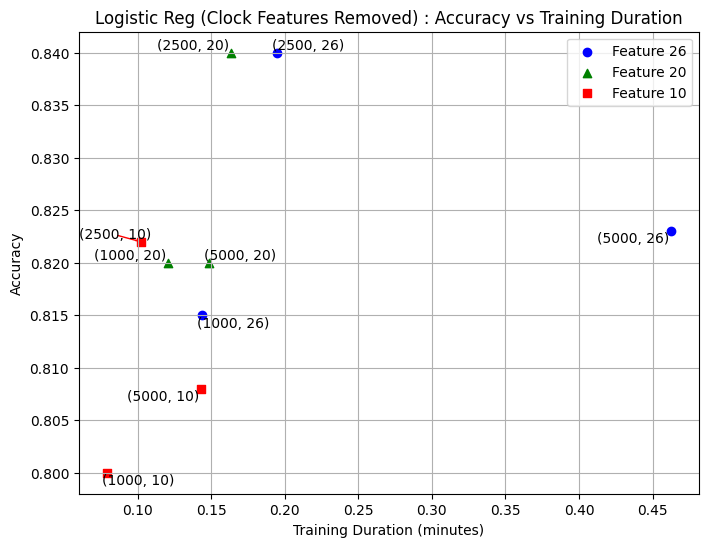

In [57]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(training_duration_lr) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(logistic_reg_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(training_duration_lr) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(logistic_reg_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(training_duration_lr, logistic_reg_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Training Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Logistic Reg (Clock Features Removed) : Accuracy vs Training Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


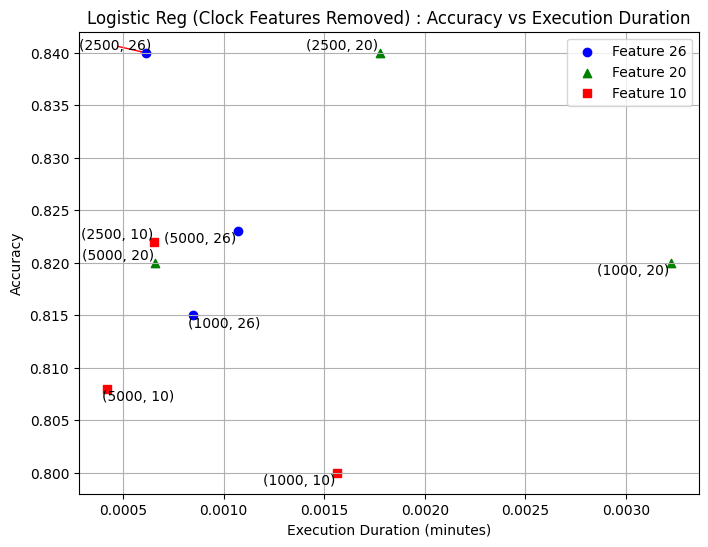

In [58]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(execution_duration_lr) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(logistic_reg_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(execution_duration_lr) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(logistic_reg_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(execution_duration_lr, logistic_reg_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Execution Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Logistic Reg (Clock Features Removed) : Accuracy vs Execution Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


In [59]:
for elem in execution_duration_lr:
  print(elem)

0.0008470853169759115
0.0032214800516764323
0.0015620549519856771
0.0006131331125895182
0.0017775376637776694
0.0006567955017089844
0.0010729471842447916
0.0006608804066975912
0.0004215081532796224


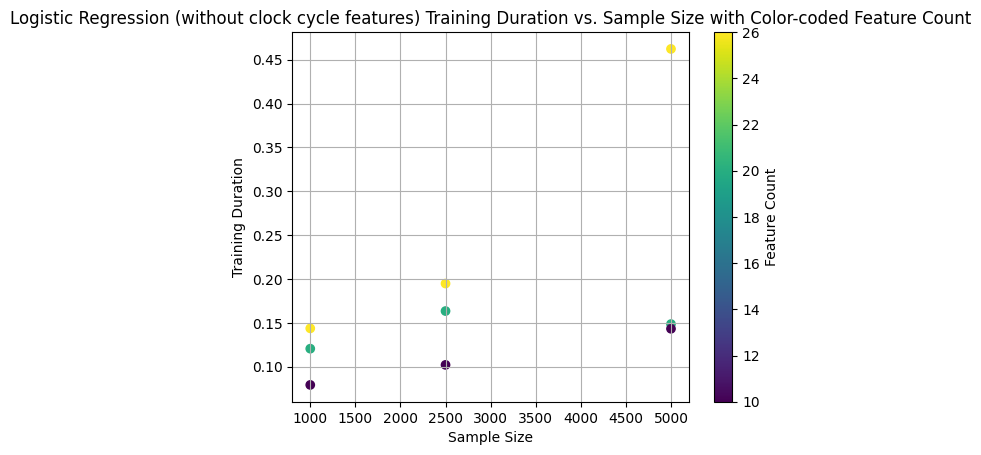

In [60]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, training_duration_lr, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Training Duration')
plt.title('Logistic Regression (without clock cycle features) Training Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

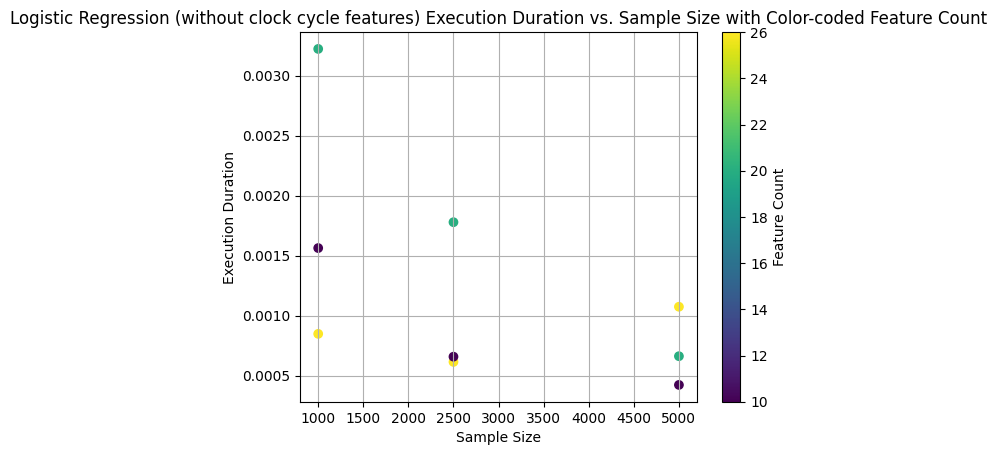

In [61]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, execution_duration_lr, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Execution Duration')
plt.title('Logistic Regression (without clock cycle features) Execution Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

Logistic Reg no clock features


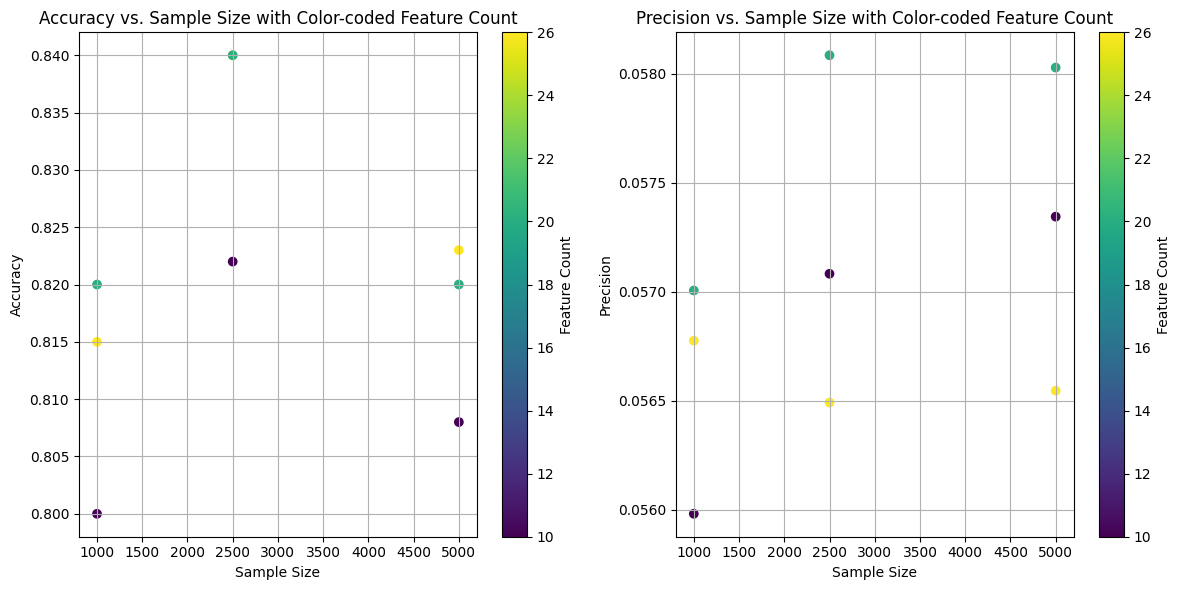

In [62]:
# Sample features
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

sample_sizes, feature_counts = zip(*sample_features)

print('Logistic Reg no clock features')
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(sample_sizes, logistic_reg_acc, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')
# Add a grid
plt.grid(True)

# Plot Precision
plt.subplot(1, 2, 2)
plt.scatter(sample_sizes, logistic_reg_prec, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Precision')
plt.title('Precision vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

plt.tight_layout()

# Add a grid
plt.grid(True)

plt.show()


# Decision Tree Classifier


In [63]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [64]:
training_duration_dt = []
execution_duration_dt = []
dt_prec = []
dt_acc = []

# Number of repetitions for each combination
repetitions = 15

for i in range(9):
    acc = 0
    prec = 0
    training_duration = 0
    execution_duration = 0
    for _ in range(repetitions):
        start_time = time.time()
        model = DecisionTreeClassifier(random_state=42)
        model.fit(train_x_list[i], train_y_list[i])
        end_time = time.time()

        training_duration += end_time - start_time

        start = time.time()
        y_pred = model.predict(test_x_list[i])
        end = time.time()
        execution_duration += end - start


        accuracy = accuracy_score(test_y_list[i], y_pred)
        precision = precision_score(test_y_list[i], y_pred, average='weighted')

        acc += accuracy
        prec += precision

        model_name = f"Decision Tree {i+1}"
        config_row = [model_name, f"{precision:.4f}", f"{accuracy:.4f}", f"{training_duration:.4f}", f"{execution_duration:.4f}"]
        config_matrix.append(config_row)

    # Calculate average metrics
    dt_acc.append(acc/repetitions)
    dt_prec.append(precision/repetitions)
    training_duration_dt.append(training_duration/repetitions)
    execution_duration_dt.append(execution_duration/repetitions)


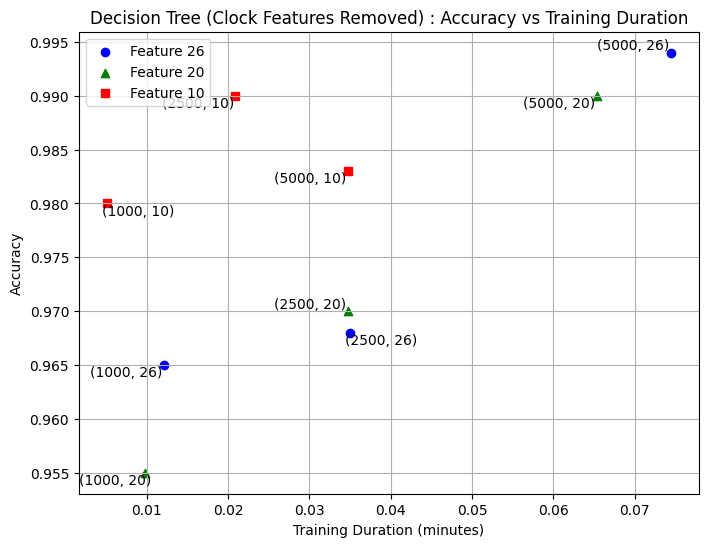

In [65]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(training_duration_dt) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(dt_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(training_duration_dt) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(dt_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(training_duration_dt, dt_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Training Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Decision Tree (Clock Features Removed) : Accuracy vs Training Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


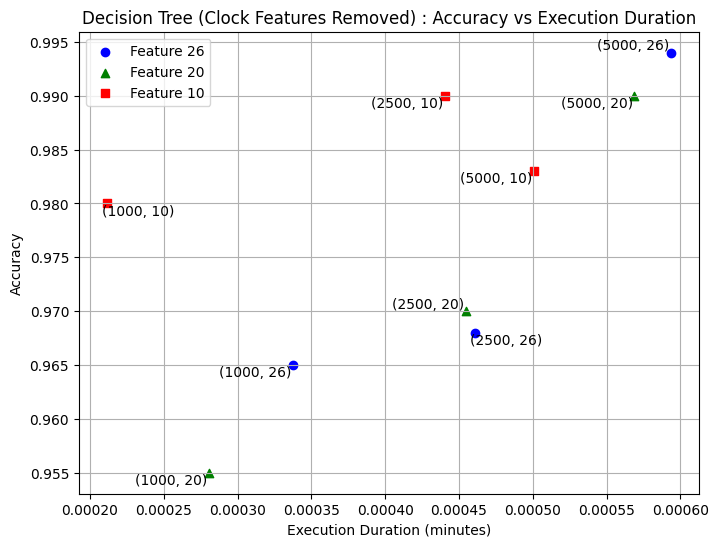

In [66]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(execution_duration_dt) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(dt_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(execution_duration_dt) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(dt_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(execution_duration_dt, dt_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Execution Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Decision Tree (Clock Features Removed) : Accuracy vs Execution Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


#Decision Tree no clock cycle features


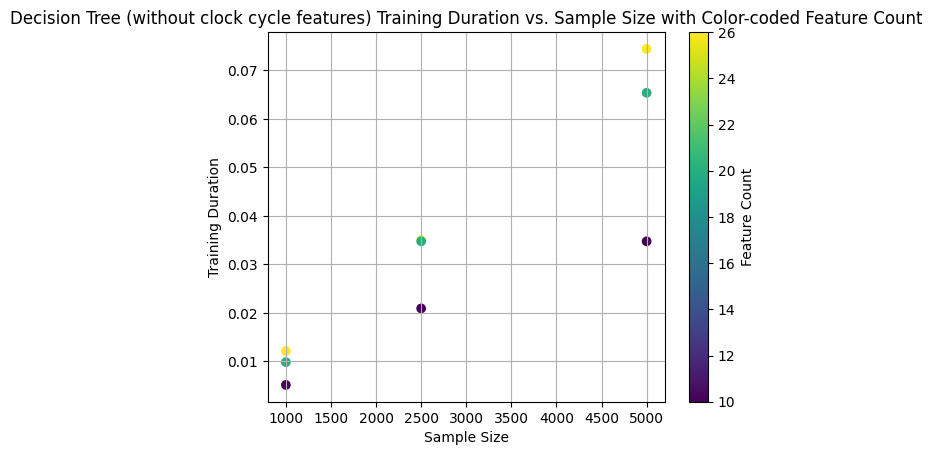

In [67]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, training_duration_dt, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Training Duration')
plt.title('Decision Tree (without clock cycle features) Training Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

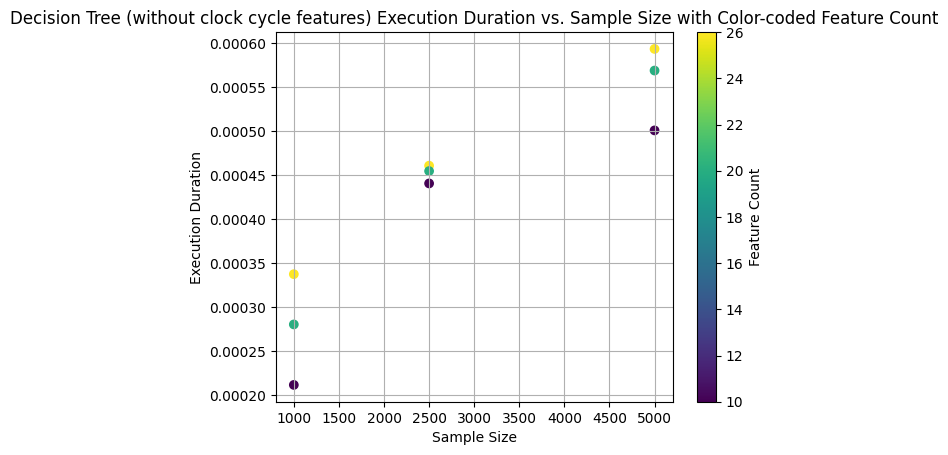

In [68]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, execution_duration_dt, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Execution Duration')
plt.title('Decision Tree (without clock cycle features) Execution Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

Decision Tree no clock features


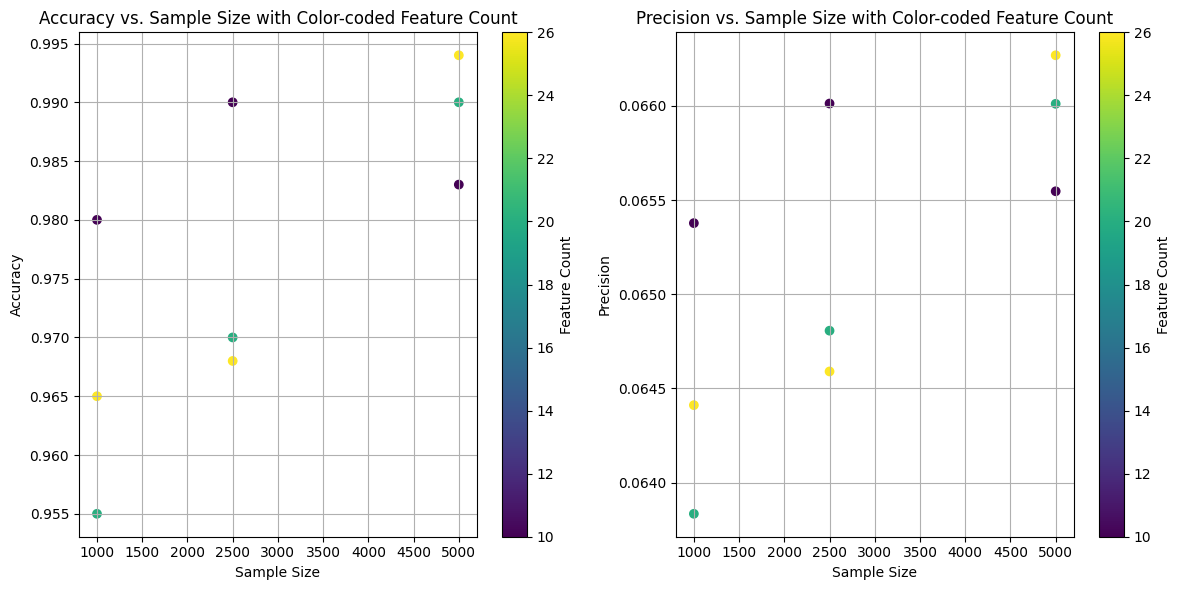

In [69]:
# Sample features
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

sample_sizes, feature_counts = zip(*sample_features)

print('Decision Tree no clock features')
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(sample_sizes, dt_acc, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

# Plot Precision
plt.subplot(1, 2, 2)
plt.scatter(sample_sizes, dt_prec, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Precision')
plt.title('Precision vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

plt.tight_layout()

# Add a grid
plt.grid(True)

plt.show()

#Random Forest Classifier


#Random Forest no clock cycle features


In [70]:
training_duration_rf = []
execution_duration_rf = []
rf_prec = []
rf_acc = []

# Number of repetitions for each combination
repetitions = 15

for i in range(9):
    acc = 0
    prec = 0
    training_duration = 0
    execution_duration = 0
    for _ in range(repetitions):
        start_time = time.time()
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(train_x_list[i], train_y_list[i])
        end_time = time.time()

        training_duration += end_time - start_time

        start = time.time()
        y_pred = model.predict(test_x_list[i])
        end = time.time()
        execution_duration += end - start


        accuracy = accuracy_score(test_y_list[i], y_pred)
        precision = precision_score(test_y_list[i], y_pred, average='weighted')

        acc += accuracy
        prec += precision

        model_name = f"Random Forest {i+1}"
        config_row = [model_name, f"{precision:.4f}", f"{accuracy:.4f}", f"{training_duration:.4f}", f"{execution_duration:.4f}"]
        config_matrix.append(config_row)

    # Calculate average metrics
    rf_acc.append(acc/repetitions)
    rf_prec.append(precision/repetitions)
    training_duration_rf.append(training_duration/repetitions)
    execution_duration_rf.append(execution_duration/repetitions)


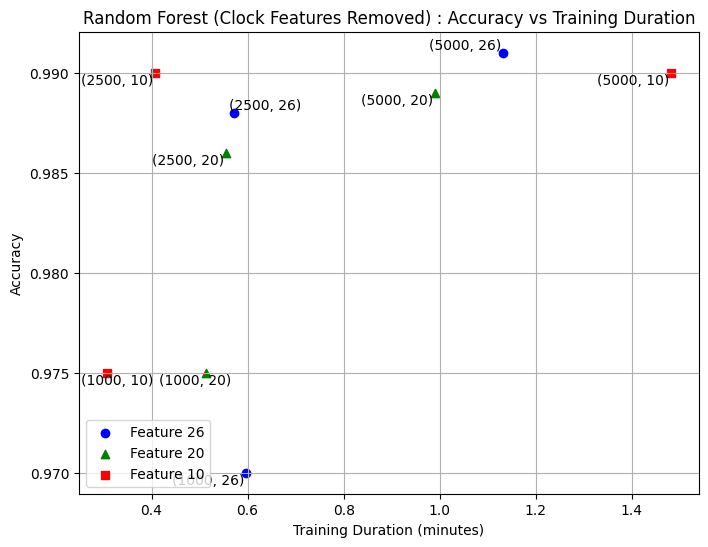

In [71]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(training_duration_rf) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(rf_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(training_duration_rf) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(rf_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(training_duration_rf, rf_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Training Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Random Forest (Clock Features Removed) : Accuracy vs Training Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


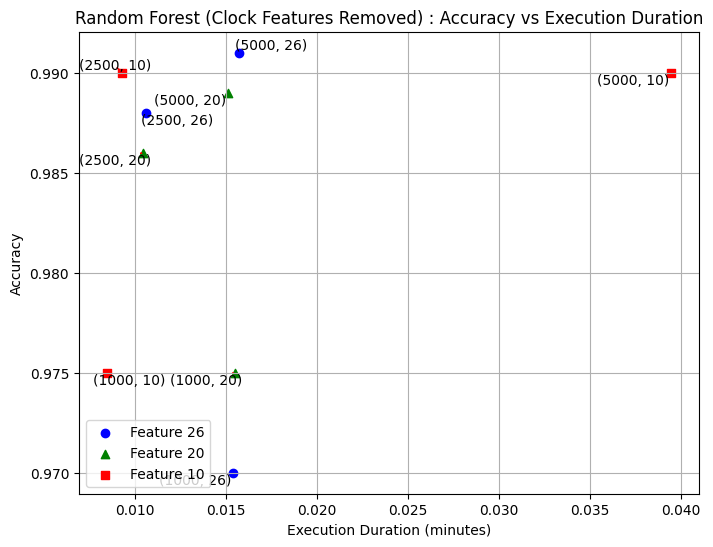

In [72]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(execution_duration_rf) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(rf_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(execution_duration_rf) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(rf_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(execution_duration_rf, rf_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Execution Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Random Forest (Clock Features Removed) : Accuracy vs Execution Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


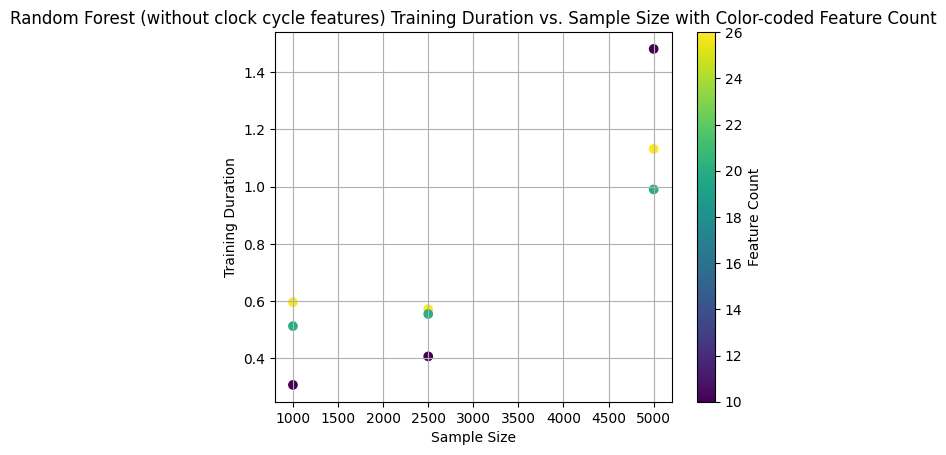

In [73]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, training_duration_rf, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Training Duration')
plt.title('Random Forest (without clock cycle features) Training Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

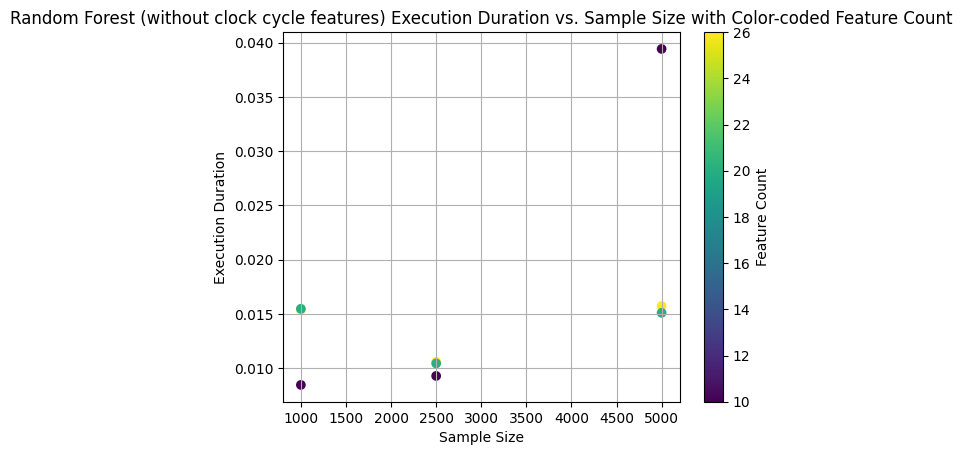

In [74]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, execution_duration_rf, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Execution Duration')
plt.title('Random Forest (without clock cycle features) Execution Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

Random Forest no clock features


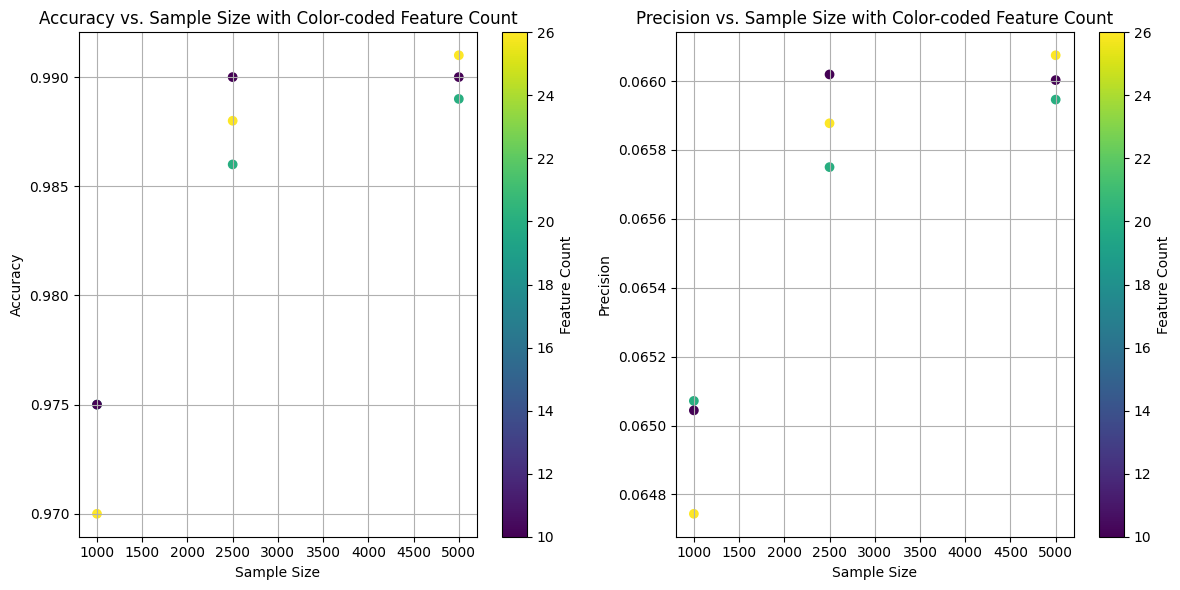

In [75]:
# Sample features
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

sample_sizes, feature_counts = zip(*sample_features)

print('Random Forest no clock features')
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(sample_sizes, rf_acc, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')
# Add a grid
plt.grid(True)

# Plot Precision
plt.subplot(1, 2, 2)
plt.scatter(sample_sizes, rf_prec, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Precision')
plt.title('Precision vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

plt.tight_layout()

# Add a grid
plt.grid(True)

plt.show()

# SVM

#SVM no clock cycle features


In [76]:
from sklearn.svm import SVC

training_duration_svm = []
execution_duration_svm = []
svm_prec = []
svm_acc = []

# Number of repetitions for each combination
repetitions = 15

for i in range(9):
    acc = 0
    prec = 0
    training_duration = 0
    execution_duration = 0
    for _ in range(repetitions):
        start_time = time.time()
        model = SVC(kernel='linear', C=3, gamma='auto')
        model.fit(train_x_list[i], train_y_list[i])
        end_time = time.time()

        training_duration += end_time - start_time

        start = time.time()
        y_pred = model.predict(test_x_list[i])
        end = time.time()
        execution_duration += end - start


        accuracy = accuracy_score(test_y_list[i], y_pred)
        precision = precision_score(test_y_list[i], y_pred, average='weighted')

        acc += accuracy
        prec += precision

        model_name = f"SVM {i+1}"
        config_row = [model_name, f"{precision:.4f}", f"{accuracy:.4f}", f"{training_duration:.4f}", f"{execution_duration:.4f}"]
        config_matrix.append(config_row)

    # Calculate average metrics
    svm_acc.append(acc/repetitions)
    svm_prec.append(precision/repetitions)
    training_duration_svm.append(training_duration/repetitions)
    execution_duration_svm.append(execution_duration/repetitions)


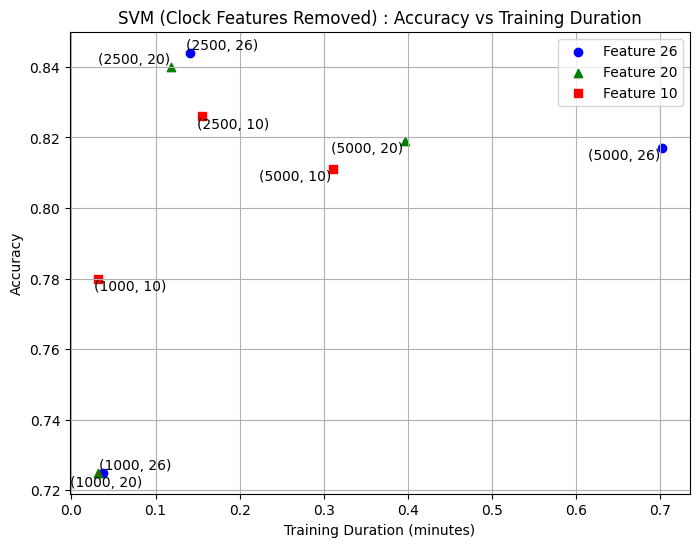

In [77]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(training_duration_svm) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(svm_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(training_duration_svm) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(svm_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(training_duration_svm, svm_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Training Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('SVM (Clock Features Removed) : Accuracy vs Training Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


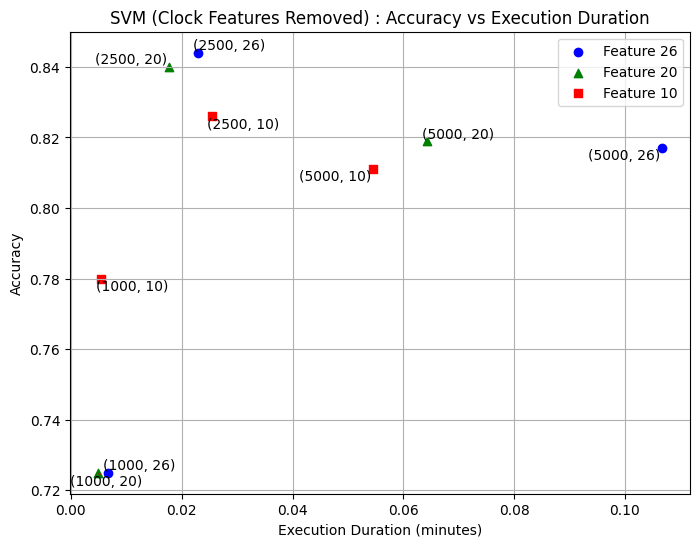

In [78]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(execution_duration_svm) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(svm_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(execution_duration_svm) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(svm_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(execution_duration_svm, svm_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Execution Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('SVM (Clock Features Removed) : Accuracy vs Execution Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


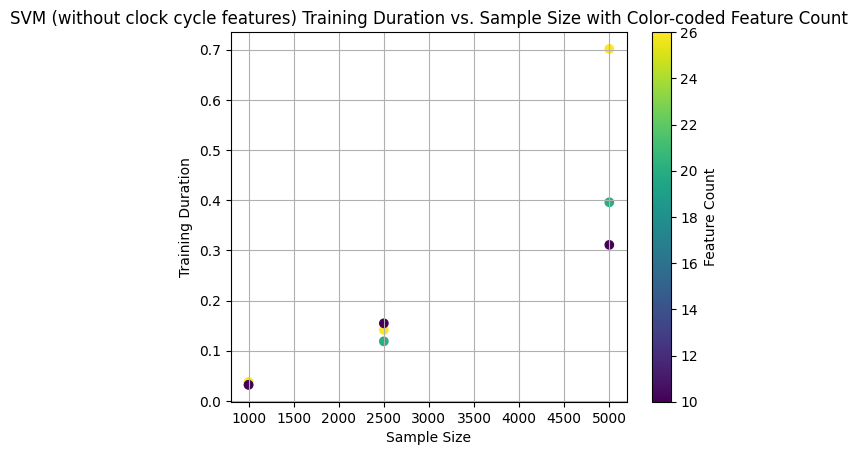

In [79]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, training_duration_svm, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Training Duration')
plt.title('SVM (without clock cycle features) Training Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

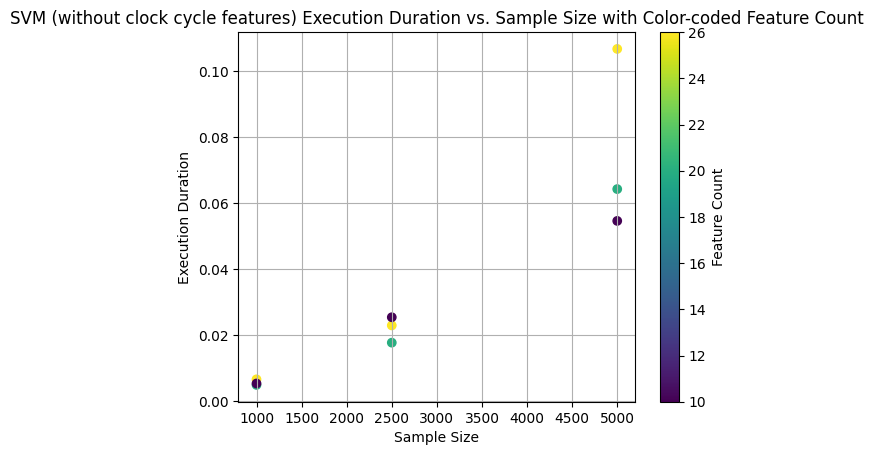

In [80]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, execution_duration_svm, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Execution Duration')
plt.title('SVM (without clock cycle features) Execution Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

SVM no clock features


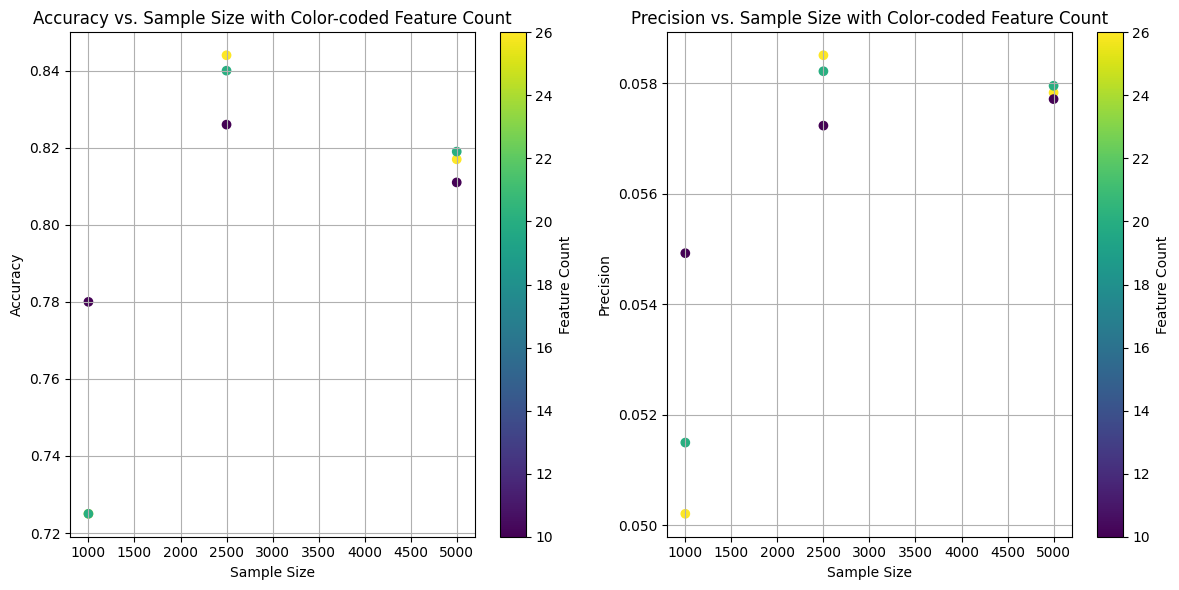

In [81]:
# Sample features
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

sample_sizes, feature_counts = zip(*sample_features)

print('SVM no clock features')
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(sample_sizes, svm_acc, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')
# Add a grid
plt.grid(True)

# Plot Precision
plt.subplot(1, 2, 2)
plt.scatter(sample_sizes, svm_prec, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Precision')
plt.title('Precision vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

plt.tight_layout()

# Add a grid
plt.grid(True)

plt.show()

# 1st Neural Network

If you use Neural Networks, in Colab do "Runtime > Change Runtime type" to TPU or GPU.

The functions `build_model()` and `train_model(..)` are very similar to what you encountered in the [notebooks on Neural Networks](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [82]:
def make_sequential_model(sample_size, layer_sizes,
                          hidden_activation_function="relu",
                          out_activation_function="softmax",
                          loss_fun="sparse_categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0],
                  input_dim = sample_size) )

  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )

  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )


  model.compile(loss=loss_fun,
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)

  return model


def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more:
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))


def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000,
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training
            (thanks to the ModelCheckpoint callback (see the implementation
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.

  overwrite: boolean
            If true, the model will be built and trained from scratch,
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the
            specified number of epochs
  """

  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True)


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs,
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb],
                      validation_split=validation_split )

  return history

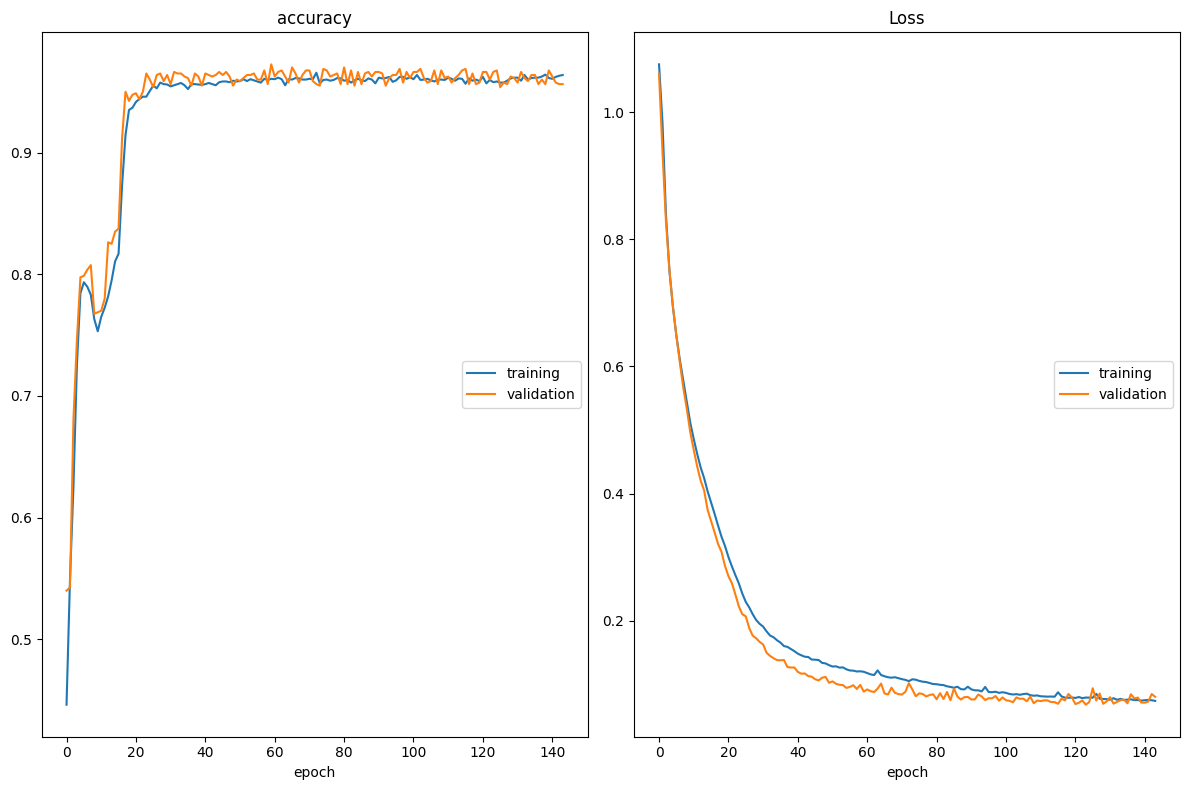

accuracy
	training         	 (min:    0.446, max:    0.966, cur:    0.964)
	validation       	 (min:    0.540, max:    0.973, cur:    0.956)
Loss
	training         	 (min:    0.074, max:    1.075, cur:    0.074)
	validation       	 (min:    0.068, max:    1.061, cur:    0.080)
Restoring model weights from the end of the best epoch: 124.
100/100 [==============================] - 1s 13ms/step - loss: 0.0737 - accuracy: 0.9638 - val_loss: 0.0801 - val_accuracy: 0.9563
Epoch 144: early stopping
32/32 [==============================] - 0s 1ms/step


In [84]:
training_duration_nn = []
execution_duration_nn = []
nn_acc = []
nn_prec = []

# Number of repetitions for each combination
repetitions = 5

for i in range(9):
    acc = 0
    prec = 0
    training_duration = 0
    execution_duration = 0
    for _ in range(repetitions):
        print(f'{i}th model is in the {_}th repetition')

        sample_size = train_x_list[i].shape[1]
        num_of_classes=len(class_names)
        nnfile = nn_file = my_path + f"nn{i+1}.h5"
        shallow_architecture=[20, 10, 5, num_of_classes]

        start_time = time.time()
        model = make_sequential_model(sample_size, shallow_architecture)
        history = train_model(model, nn_file, train_x_list[i], train_y_list[i], seed=3)
        end_time = time.time()

        training_duration += end_time - start_time

        start = time.time()
        y_pred_ = model.predict(test_x_list[i])
        end = time.time()
        execution_duration += end - start

        y_pred = np.argmax(y_pred_, axis=1)

        accuracy = accuracy_score(test_y_list[i], y_pred)
        precision = precision_score(test_y_list[i], y_pred, average='weighted')

        acc += accuracy
        prec += precision

        model_name = f"Neural Network {i+1}"
        config_row = [model_name, f"{precision:.4f}", f"{accuracy:.4f}", f"{training_duration:.4f}", f"{execution_duration:.4f}"]
        config_matrix.append(config_row)

    # Calculate average metrics
    nn_acc.append(acc/repetitions)
    nn_prec.append(precision/repetitions)
    training_duration_nn.append(training_duration/repetitions)
    execution_duration_nn.append(execution_duration/repetitions)


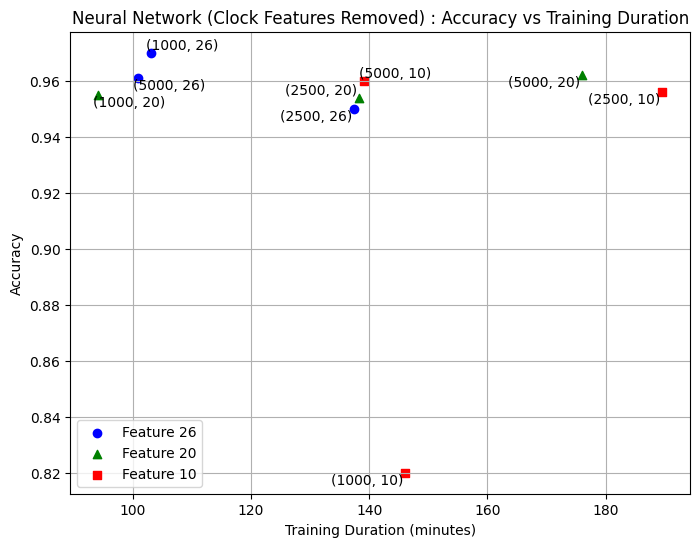

In [85]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(training_duration_nn) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(nn_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(training_duration_nn) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(nn_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(training_duration_nn, nn_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Training Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Neural Network (Clock Features Removed) : Accuracy vs Training Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


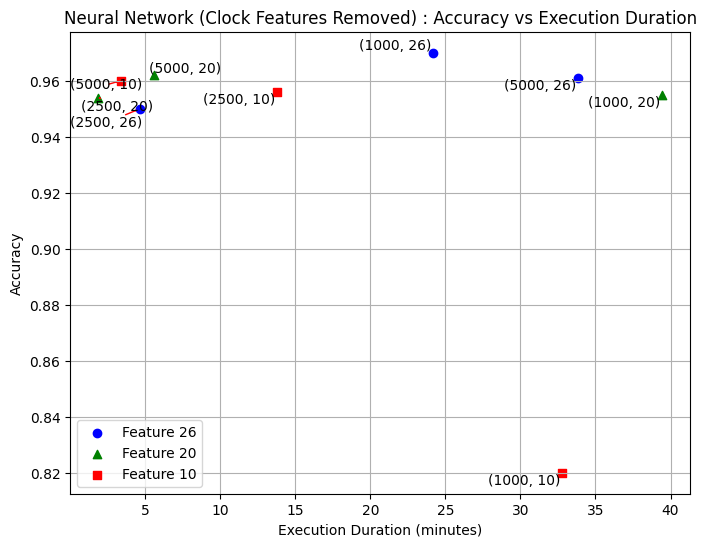

In [86]:
# Sample features for each data point
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Mapping feature number to marker type and color
feature_marker_color_mapping = {
    26: ('o', 'blue'),
    20: ('^', 'green'),
    10: ('s', 'red')
}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
added_features = set()  # To keep track of features already added to the legend
for sample, feature in sample_features:
    marker, color = feature_marker_color_mapping[feature]
    label = f'Feature {feature}'
    if feature not in added_features:
        plt.scatter([td for i, td in enumerate(execution_duration_nn) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(nn_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color, label=label)
        added_features.add(feature)
    else:
        plt.scatter([td for i, td in enumerate(execution_duration_nn) if sample_features[i] == (sample, feature)],
                    [acc for i, acc in enumerate(nn_acc) if sample_features[i] == (sample, feature)],
                    marker=marker, color=color)

# Add sample feature tuple as text next to each point
texts = [plt.text(td, acc, f"({sample}, {feature})", ha='center', va='center')
         for td, acc, (sample, feature) in zip(execution_duration_nn, nn_acc, sample_features)]

# Adjust text for better readability
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding labels and title
plt.xlabel('Execution Duration (minutes)')
plt.ylabel('Accuracy')
plt.title('Neural Network (Clock Features Removed) : Accuracy vs Execution Duration')

# Adding grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


#NN no clock cycle features


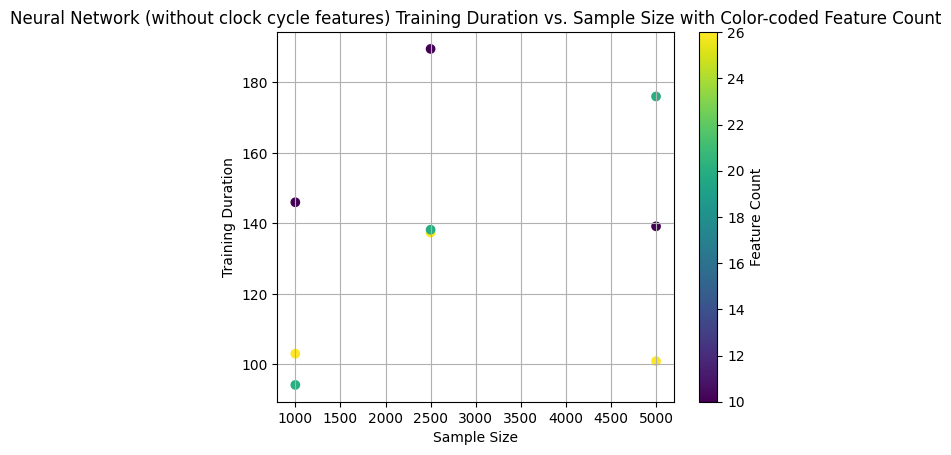

In [87]:
import matplotlib.pyplot as plt

sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

# Assuming 'sample_features' is your list of tuples and 'training_durations' is your list of durations
sample_sizes, feature_counts = zip(*sample_features)

plt.scatter(sample_sizes, training_duration_nn, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Training Duration')
plt.title('Neural Network (without clock cycle features) Training Duration vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

# Add a grid
plt.grid(True)

plt.show()

Neural Network no clock features


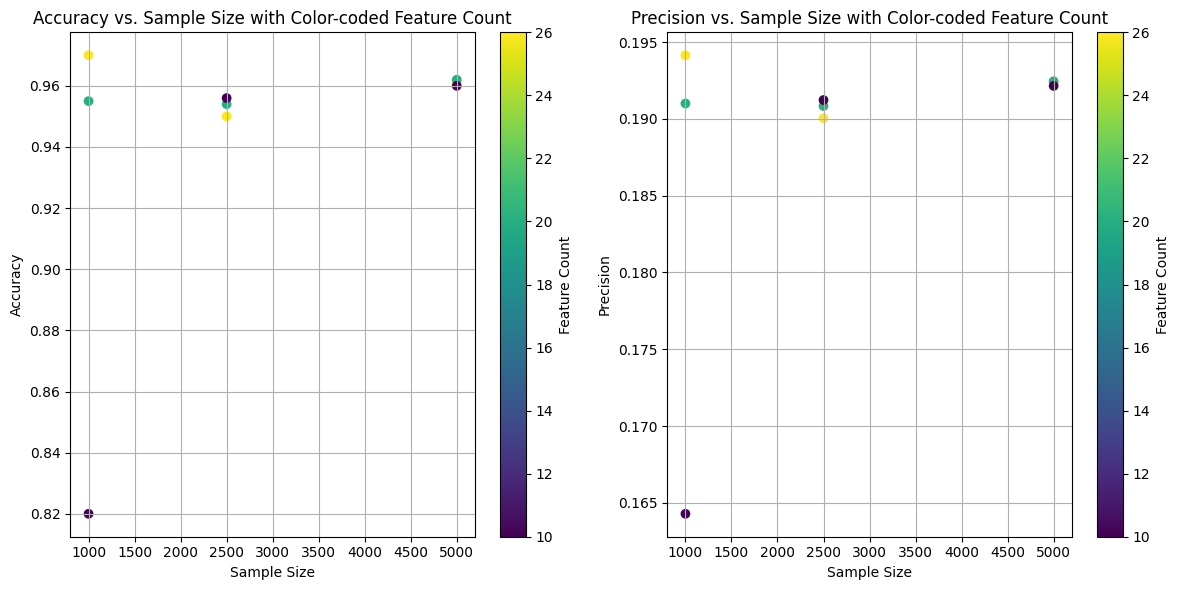

In [88]:
# Sample features
sample_features = [(1000, 26), (1000, 20), (1000, 10), (2500, 26), (2500, 20), (2500, 10), (5000, 26), (5000, 20), (5000, 10)]

sample_sizes, feature_counts = zip(*sample_features)

print('Neural Network no clock features')
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.scatter(sample_sizes, nn_acc, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')
# Add a grid
plt.grid(True)

# Plot Precision
plt.subplot(1, 2, 2)
plt.scatter(sample_sizes, nn_prec, c=feature_counts, cmap='viridis')
plt.xlabel('Sample Size')
plt.ylabel('Precision')
plt.title('Precision vs. Sample Size with Color-coded Feature Count')
plt.colorbar(label='Feature Count')

plt.tight_layout()

# Add a grid
plt.grid(True)

plt.show()

In [89]:
# Convert the list to a NumPy array if needed
config_matrix = np.array(config_matrix)
print(config_matrix)

[['Logistic Regression 1' '0.8516' '0.8150' '0.1741' '0.0004']
 ['Logistic Regression 1' '0.8516' '0.8150' '0.3084' '0.0008']
 ['Logistic Regression 1' '0.8516' '0.8150' '0.4726' '0.0011']
 ...
 ['Neural Network 9' '0.9607' '0.9600' '417.7444' '8.5556']
 ['Neural Network 9' '0.9607' '0.9600' '556.2721' '13.4461']
 ['Neural Network 9' '0.9607' '0.9600' '695.9548' '16.8894']]


In [91]:
import numpy as np

def average_duplicates(config_matrix):
    model_data = {}

    for row in config_matrix:
        model_name = row[0]
        if model_name not in model_data:
            model_data[model_name] = {
                'sums': np.array(row[1:], dtype=float),
                'count': 1
            }
        else:
            model_data[model_name]['sums'] += np.array(row[1:], dtype=float)
            model_data[model_name]['count'] += 1

    new_matrix = []

    for model_name, data in model_data.items():
        avg_values = data['sums'] / data['count']
        new_row = [model_name] + list(avg_values)
        new_matrix.append(new_row)

    return new_matrix

new_matrix = average_duplicates(config_matrix)
new_matrix

[['Logistic Regression 1',
  0.8515999999999999,
  0.8149999999999996,
  1.1811933333333333,
  0.008286666666666666],
 ['Logistic Regression 2',
  0.8551000000000001,
  0.8200000000000002,
  0.9137666666666667,
  0.03408],
 ['Logistic Regression 3',
  0.8397000000000001,
  0.8000000000000002,
  0.7124666666666667,
  0.01857333333333333],
 ['Logistic Regression 4',
  0.8474000000000003,
  0.84,
  1.4516733333333334,
  0.00534],
 ['Logistic Regression 5',
  0.8712999999999999,
  0.84,
  1.2702466666666665,
  0.010459999999999999],
 ['Logistic Regression 6',
  0.8561999999999999,
  0.8219999999999996,
  0.9428866666666667,
  0.007033333333333334],
 ['Logistic Regression 7',
  0.8482000000000002,
  0.8230000000000003,
  3.2394266666666667,
  0.0051133333333333334],
 ['Logistic Regression 8',
  0.8704,
  0.8200000000000002,
  1.2035066666666665,
  0.006693333333333333],
 ['Logistic Regression 9',
  0.8602000000000003,
  0.8079999999999999,
  1.1128266666666666,
  0.0033733333333333332],
 ['

In [96]:
def make_last_two_negative(config_matrix):
    modified_matrix = []
    for sublist in config_matrix:
        modified_sublist = sublist[:]  # Create a copy of the sublist
        modified_sublist[-2:] = [-abs(float(modified_sublist[-2])), -abs(float(modified_sublist[-1]))]
        modified_matrix.append(modified_sublist)
    return modified_matrix
neg_new_mat = make_last_two_negative(new_matrix)
neg_new_mat = np.array(neg_new_mat)
neg_new_mat

array([['Logistic Regression 1', '0.8515999999999999',
        '0.8149999999999996', '-1.1811933333333333',
        '-0.008286666666666666'],
       ['Logistic Regression 2', '0.8551000000000001',
        '0.8200000000000002', '-0.9137666666666667', '-0.03408'],
       ['Logistic Regression 3', '0.8397000000000001',
        '0.8000000000000002', '-0.7124666666666667',
        '-0.01857333333333333'],
       ['Logistic Regression 4', '0.8474000000000003', '0.84',
        '-1.4516733333333334', '-0.00534'],
       ['Logistic Regression 5', '0.8712999999999999', '0.84',
        '-1.2702466666666665', '-0.010459999999999999'],
       ['Logistic Regression 6', '0.8561999999999999',
        '0.8219999999999996', '-0.9428866666666667',
        '-0.007033333333333334'],
       ['Logistic Regression 7', '0.8482000000000002',
        '0.8230000000000003', '-3.2394266666666667',
        '-0.0051133333333333334'],
       ['Logistic Regression 8', '0.8704', '0.8200000000000002',
        '-1.2035066

In [93]:
!pip install oapackage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for oapackage: filename=OApackage-2.7.13-cp310-cp310-linux_x86_64.whl size=21422730 sha256=69fef41dd9ce14bc9a2f7593140bef52caa808a5e0763b0571555271365e02ab
  Stored in directory: /root/.cache/pip/wheels/55/33/3b/a3785f11265330e98aed540e94755365b117e899646dbab210
Successfully built oapackage


In [97]:
import oapackage
# Extract the relevant columns (e.g., accuracy, precision, training time, execution time)
criteria_matrix = neg_new_mat[:, 1:]

# Initialize ParetoDoubleLong
pareto = oapackage.ParetoDoubleLong()

# Add data points to ParetoDoubleLong
for ii in range(criteria_matrix.shape[0]):
    w = oapackage.doubleVector()
    for value in criteria_matrix[ii, :]:
        w.push_back(float(value))
    pareto.addvalue(w, ii)


# Identify Pareto optimal solutions
pareto_indices = pareto.allindices()

# Extract Pareto optimal configurations from the original matrix
pareto_configurations = criteria_matrix[pareto_indices, :]

In [98]:
pareto_configurations
#'Decision Tree (1000, 10)', 'Decision Tree (2500, 10)', 'Decision Tree (5000, 26)'
#Decision Tree 3, 6, 7

array([['0.9807000000000002', '0.9800000000000003',
        '-0.040666666666666657', '-0.0016266666666666667'],
       ['0.9901999999999999', '0.9900000000000001',
        '-0.16678666666666667', '-0.003506666666666667'],
       ['0.9939999999999999', '0.9939999999999999',
        '-0.5945733333333333', '-0.004606666666666666']], dtype='<U32')

In [ ]:
import numpy as np

config_matrix = np.array([
    ['Logistic Regression 1', '0.8516', '0.8150', '-1.1811933333333333', '-0.008286666666666666'],
    ['Logistic Regression 2', '0.8551', '0.82', '-0.9137666666666667', '-0.03408'],
    ['Logistic Regression 3', '0.8397', '0.8', '-0.7124666666666667', '-0.01857333333333333'],
    ['Logistic Regression 4', '0.8474', '0.84', '-1.4516733333333334', '-0.00534'],
    ['Logistic Regression 5', '0.8713', '0.84', '-1.2702466666666665', '-0.010459999999999999'],
    ['Logistic Regression 6', '0.8562', '0.822', '-0.9428866666666667', '-0.007033333333333334'],
    ['Logistic Regression 7', '0.8482', '0.823', '-3.2394266666666667', '-0.0051133333333333334'],
    ['Logistic Regression 8', '0.8704', '0.82', '-1.2035066666666665', '-0.006693333333333333'],
    ['Logistic Regression 9', '0.8602', '0.808', '-1.1128266666666666', '-0.0033733333333333332'],
    ['Decision Tree 1', '0.9662', '0.965', '-0.09738', '-0.0027933333333333334'],
    ['Decision Tree 2', '0.9575', '0.955', '-0.07914', '-0.0022400000000000002'],
    ['Decision Tree 3', '0.9807', '0.98', '-0.040666666666666657', '-0.0016266666666666667'],
    ['Decision Tree 4', '0.9689', '0.968', '-0.25937333333333334', '-0.003433333333333334'],
    ['Decision Tree 5', '0.9721', '0.97', '-0.2817', '-0.003626666666666667'],
    ['Decision Tree 6', '0.9902', '0.99', '-0.16678666666666667', '-0.003506666666666667'],
    ['Decision Tree 7', '0.9940', '0.994', '-0.5945733333333333', '-0.004606666666666666'],
    ['Decision Tree 8', '0.9902', '0.99', '-0.52482', '-0.004533333333333334'],
    ['Decision Tree 9', '0.9832', '0.983', '-0.2987', '-0.004293333333333333'],
    ['Random Forest 1', '0.9712', '0.97', '-4.172893333333334', '-0.11211333333333331'],
    ['Random Forest 2', '0.9761', '0.975', '-4.421093333333332', '-0.13348666666666667'],
    ['Random Forest 3', '0.9757', '0.975', '-2.569526666666667', '-0.06844'],
    ['Random Forest 4', '0.9882', '0.988', '-4.870513333333333', '-0.09208000000000001'],
    ['Random Forest 5', '0.9863', '0.986', '-4.275166666666666', '-0.08136000000000002'],
    ['Random Forest 6', '0.9903', '0.99', '-3.260993333333334', '-0.07432666666666667'],
    ['Random Forest 7', '0.9911', '0.991', '-8.715773333333335', '-0.12692666666666666'],
    ['Random Forest 8', '0.9892', '0.989', '-8.084453333333334', '-0.11752666666666668'],
    ['Random Forest 9', '0.99', '0.99', '-11.998839999999998', '-0.3207666666666667'],
    ['SVM 1', '0.7531', '0.725', '-0.2639', '-0.04723333333333333'],
    ['SVM 2', '0.7724', '0.725', '-0.24515333333333336', '-0.04001333333333333'],
    ['SVM 3', '0.8239', '0.78', '-0.25906', '-0.04292'],
    ['SVM 4', '0.8776', '0.844', '-1.1111600000000001', '-0.1780533333333333'],
    ['SVM 5', '0.8733', '0.84', '-1.0300933333333335', '-0.15642666666666666'],
    ['SVM 6', '0.8585', '0.826', '-1.1983599999999999', '-0.19762'],
    ['SVM 7', '0.8675', '0.817', '-6.497553333333333', '-1.0308199999999998'],
    ['SVM 8', '0.8693', '0.819', '-2.824653333333333', '-0.4663000000000001'],
    ['SVM 9', '0.8657', '0.811', '-2.490013333333333', '-0.43576000000000004'],
    ['Neural Network 1', '0.9707', '0.97', '-310.50541999999996', '-79.18106'],
    ['Neural Network 2', '0.955', '0.955', '-283.02097999999995', '-127.63025999999999'],
    ['Neural Network 3', '0.8214', '0.82', '-441.68528', '-131.65172'],
    ['Neural Network 4', '0.9502', '0.95', '-412.311', '-15.32444'],
    ['Neural Network 5', '0.9542', '0.954', '-414.23426', '-5.719460000000001'],
    ['Neural Network 6', '0.9561', '0.956', '-572.4095599999999', '-37.60218'],
    ['Neural Network 7', '0.9615', '0.961', '-303.28528', '-109.30708'],
    ['Neural Network 8', '0.9622', '0.962', '-527.8997999999999', '-27.573500000000003'],
    ['Neural Network 9', '0.9607', '0.96', '-417.29206000000005', '-10.331299999999999']
])

print(config_matrix)

In [99]:
logistic_reg_acc


[0.8149999999999996,
 0.8200000000000002,
 0.8000000000000002,
 0.84,
 0.84,
 0.8219999999999996,
 0.8230000000000003,
 0.8200000000000002,
 0.8079999999999999]

In [100]:
dt_acc

[0.965,
 0.955,
 0.9800000000000003,
 0.968,
 0.9700000000000002,
 0.9900000000000001,
 0.9939999999999999,
 0.9900000000000001,
 0.9830000000000002]

In [101]:
rf_acc

[0.9700000000000002,
 0.9749999999999998,
 0.9749999999999998,
 0.9879999999999997,
 0.9860000000000002,
 0.9900000000000001,
 0.9909999999999998,
 0.9890000000000003,
 0.9900000000000001]

In [102]:
svm_acc

[0.7249999999999998,
 0.7249999999999998,
 0.7799999999999999,
 0.8439999999999999,
 0.84,
 0.8260000000000001,
 0.8170000000000001,
 0.8189999999999997,
 0.811]

In [103]:
nn_acc

[0.97,
 0.9549999999999998,
 0.82,
 0.95,
 0.954,
 0.9559999999999998,
 0.961,
 0.962,
 0.96]